In [1]:
import sys
sys.path.insert(0, "./../../scripts")

In [2]:
import pickle
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import ricciardi as ric
import dmft

def imshowbar(fig,ax,A,showbar=True,**kwargs):
    imsh = ax.imshow(A,**kwargs)
    if showbar:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = fig.colorbar(imsh, cax=cax, orientation="vertical")
        return cbar

In [3]:
plt.rcParams["font.sans-serif"] = ["PT Sans","DejaVu Sans"]

# Plot Time Lag Dependence of Rate Autocorrelation Tuning Width from Supp Fig S1a

In [4]:
res_dict_inits = [[None for i in range(7)] for j in range(7)]
res_dict_perts = [[None for i in range(7)] for j in range(7)]

for s_idx in range(7):
    for j_idx in range(7):
        with open("./../../model_data/dmft_vary_ffwidth_{:d}_J_{:d}".format(s_idx,j_idx)+".pkl","rb") as\
                handle:
            this_res_dict = pickle.load(handle)["dmft_res"]
        res_dict_inits[s_idx][j_idx] = {key: this_res_dict[key][:2] for key in ["rb","rm","sr","Crb","Crm","sCr",
                                                                                "mub","mum","Sigb","Sigm"]}
        res_dict_perts[s_idx][j_idx] = {key: this_res_dict[key][2:] for key in ["rb","rm","sr","Crb","Crm","sCr",
                                                                                "mub","mum","Sigb","Sigm"]}

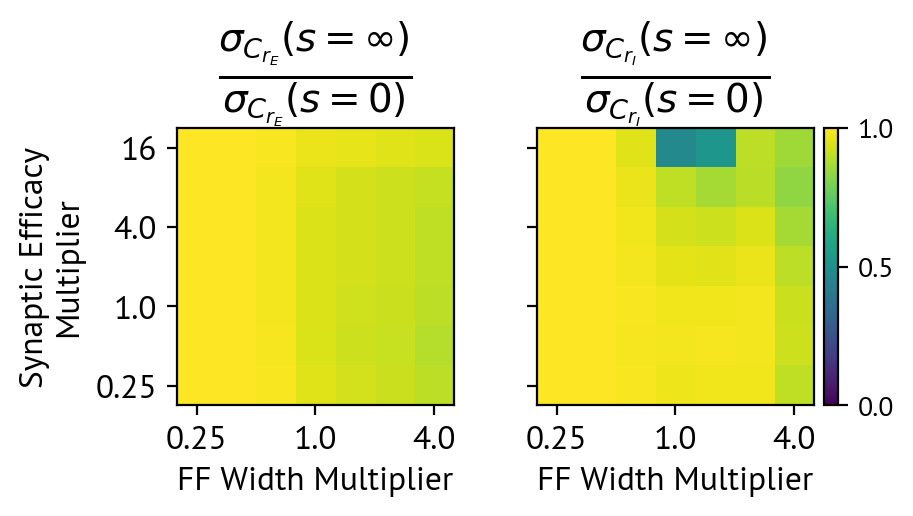

In [5]:
width_lag_dep = np.zeros((7,7,2))

for s_idx in range(7):
    for j_idx in range(7):
        width_lag_dep[s_idx,j_idx,:] = res_dict_inits[s_idx][j_idx]["sCr"][:,-1] / res_dict_inits[s_idx][j_idx]["sCr"][:,0]
        
fig,axs = plt.subplots(1,2,figsize=(2.2*2,1.8*1),dpi=200,sharey=True)

imshowbar(fig,axs[0],width_lag_dep[:,:,0],showbar=False,origin="lower",cmap="viridis",vmin=0,vmax=1)
cbar = imshowbar(fig,axs[1],width_lag_dep[:,:,1],origin="lower",cmap="viridis",vmin=0,vmax=1)
cbar.ax.set_yticks([0,0.5,1])

axs[0].set_ylabel("Synaptic Efficacy\nMultiplier",fontsize=12)
axs[0].set_yticks(np.arange(0,7,2),["0.25","1.0","4.0","16"],fontsize=12)

for i in range(2):
    axs[i].set_xticks(np.arange(0,7,3),["0.25","1.0","4.0"],fontsize=12)
    axs[i].set_xlabel("FF Width Multiplier",fontsize=12)

axs[0].set_title(r"$\frac{\sigma_{C_{r_E}}(s=\infty)}{\sigma_{C_{r_E}}(s=0)}$",fontsize=20)
axs[1].set_title(r"$\frac{\sigma_{C_{r_I}}(s=\infty)}{\sigma_{C_{r_I}}(s=0)}$",fontsize=20)

fig.savefig("./supp_fig_1a.pdf")

# Plot Determinant of Identity Minus Matched-to-Matched Effective Coupling Matrix from Supp Fig S1b

In [6]:
with open("./../../model_data/best_fit.pkl", "rb") as handle:
    res_dict = pickle.load(handle)
prms = res_dict["prms"]
eX = res_dict["best_monk_eX"]
bX = res_dict["best_monk_bX"]
aXs = res_dict["best_monk_aXs"]

ri = ric.Ricciardi()
ri.set_up_nonlinearity("./../../model_data/phi_int")

tau = np.array([ri.tE,ri.tI],dtype=np.float32)
W = prms["J"]*np.array([[1,-prms["gE"]],[1./prms["beta"],-prms["gI"]/prms["beta"]]],dtype=np.float32)
Ks = np.array([prms["K"],prms["K"]/4],dtype=np.float32)
H = bX*prms["K"]*prms["J"]*np.array([prms["hE"],prms["hI"]/prms["beta"]],dtype=np.float32)
eH = eX

muH = tau*H
SigH = (muH*eH)**2

muW = tau[:,None]*W*Ks
SigW = tau[:,None]**2*W**2*Ks

sW = np.array([[prms["SoriE"],prms["SoriI"]],[prms["SoriE"],prms["SoriI"]]],dtype=np.float32)
sW2 = sW**2

Loading previously saved nonlinearity


In [7]:
FE,FI,ME,MI,CE,CI = dmft.base_itp_moments("./../../model_data")
FL,ML,CL = dmft.opto_itp_moments("./../../model_data",prms["L"],prms["CVL"])
    
def base_M(mui,Sigii,out):
    out[0] = ME(mui[0],Sigii[0])[0]
    out[1] = MI(mui[1],Sigii[1])[0]
    
def base_C(mui,Sigii,Sigij,out):
    out[0] = CE(mui[0],Sigii[0],Sigij[0])[0]
    out[1] = CI(mui[1],Sigii[1],Sigij[1])[0]

def opto_M(mui,Sigii,out):
    out[0] = ML(mui[0],Sigii[0])[0]
    out[1] = MI(mui[1],Sigii[1])[0]
    
def opto_C(mui,Sigii,Sigij,out):
    out[0] = CL(mui[0],Sigii[0],Sigij[0])[0]
    out[1] = CI(mui[1],Sigii[1],Sigij[1])[0]

def block_base_M(mui,Sigii,out):
    out[0] = ME(mui[0],Sigii[0])[0]
    out[1] = MI(mui[1],Sigii[1])[0]
    out[2] = ME(mui[2],Sigii[2])[0]
    out[3] = MI(mui[3],Sigii[3])[0]
    
def block_base_C(mui,Sigii,Sigij,out):
    out[0] = CE(mui[0],Sigii[0],Sigij[0])[0]
    out[1] = CI(mui[1],Sigii[1],Sigij[1])[0]
    out[2] = CE(mui[2],Sigii[2],Sigij[2])[0]
    out[3] = CI(mui[3],Sigii[3],Sigij[3])[0]

def block_opto_M(mui,Sigii,out):
    out[0] = ML(mui[0],Sigii[0])[0]
    out[1] = MI(mui[1],Sigii[1])[0]
    out[2] = ML(mui[2],Sigii[2])[0]
    out[3] = MI(mui[3],Sigii[3])[0]
    
def block_opto_C(mui,Sigii,Sigij,out):
    out[0] = CL(mui[0],Sigii[0],Sigij[0])[0]
    out[1] = CI(mui[1],Sigii[1],Sigij[1])[0]
    out[2] = CL(mui[2],Sigii[2],Sigij[2])[0]
    out[3] = CI(mui[3],Sigii[3],Sigij[3])[0]

In [8]:
res_dict_inits = [[None for i in range(7)] for j in range(7)]
res_dict_perts = [[None for i in range(7)] for j in range(7)]

for s_idx in range(7):
    for j_idx in range(7):
        with open("./../../model_data/dmft_vary_ffwidth_{:d}_J_{:d}".format(s_idx,j_idx)+".pkl","rb") as\
                handle:
            this_res_dict = pickle.load(handle)["dmft_res"]
        res_dict_inits[s_idx][j_idx] = {key: this_res_dict[key][:2] for key in ["rb","rm","sr","Crb","Crm","sCr",
                                                                                "mub","mum","Sigb","Sigm"]}
        res_dict_perts[s_idx][j_idx] = {key: this_res_dict[key][2:] for key in ["rb","rm","sr","Crb","Crm","sCr",
                                                                                "mub","mum","Sigb","Sigm"]}

In [9]:
Twrm = 1.2
Tsav = 0.4

widths = 4**(2*np.arange(0,6+1)/6 - 1)
Js = prms["J"]*8**(2*np.arange(0,6+1)/6 - 2/3)
res_dict_decoups = [[None for i in range(7)] for j in range(7)]

for s_idx in range(7):
    width = widths[s_idx]
    for j_idx in range(7):
        # newJ = Js[j_idx]
        
        # this_prms = prms.copy()
        # this_prms["J"] = newJ
        # this_prms["SoriF"] *= width
        # this_prms["baseinp"] = dmft.wrapnormdens(90,this_prms["SoriF"]) / dmft.wrapnormdens(0,this_prms["SoriF"])
        
        # if j_idx < 3:
        #     dt = 0.01/5
        # elif j_idx < 5:
        #     dt = 0.01/8
        # else:
        #     dt = 0.01/10
        # res_dict_decoups[s_idx][j_idx] = dmft.run_decoupled_two_site_dmft(this_prms,bX,aXs[-1]/bX,eX,"./../results",
        #                                                                   ri,Twrm,Tsav,dt,
        #                                                                   struct_dict=res_dict_inits[s_idx][j_idx],
        #                                                                   which="opto",return_full=True)
        # with open("./../../model_data/decoup_resp_s_{:d}_j_{:d}.pkl".format(s_idx,j_idx),"wb") as handle:
        #     pickle.dump(res_dict_decoups[s_idx][j_idx],handle)
        
        # print("Done with s={:d}, j={:d}".format(s_idx,j_idx))
            
        with open("./../../model_data/decoup_resp_s_{:d}_j_{:d}.pkl".format(s_idx,j_idx),"rb") as handle:
            res_dict_decoups[s_idx][j_idx] = pickle.load(handle)

In [10]:
def calc_lin_resp(res_dict_init,res_dict_decoup,prms,Tsav,dt):
    tau = np.array([ri.tE,ri.tI],dtype=np.float32)
    W = prms["J"]*np.array([[1,-prms["gE"]],
                                 [1./prms["beta"],-prms["gI"]/prms["beta"]]],dtype=np.float32)
    Ks = np.array([prms["K"],prms["K"]/4],dtype=np.float32)

    muW = tau[:,None]*W*Ks
    SigW = tau[:,None]**2*W**2*Ks
    
    δrb0 = res_dict_decoup["rb"] - res_dict_init["rb"]
    δrm0 = res_dict_decoup["rm"] - res_dict_init["rm"]
    δCrb0 = res_dict_decoup["Crb"] - res_dict_init["Crb"]
    δCrm0 = res_dict_decoup["Crm"] - res_dict_init["Crm"]
    
    sr = res_dict_init["sr"]
    sCr = res_dict_init["sCr"][:,-1]

    sW = np.array([[prms["SoriE"],prms["SoriI"]],
                   [prms["SoriE"],prms["SoriI"]]],dtype=np.float32)
    sW2 = sW**2
    sWr = np.sqrt(sW2+sr**2)
    sWCr = np.sqrt(sW2+sCr**2)

    muWbb = (1 - dmft.struct_fact(180/2,sWr,sr,180)) * muW
    muWbm = dmft.struct_fact(180/2,sWr,sr,180) * muW
    muWmb = (1 - dmft.struct_fact(0,sWr,sr,180)) * muW
    muWmm = dmft.struct_fact(0,sWr,sr,180) * muW

    SigWbb = (1 - dmft.struct_fact(180/2,sWCr,sCr,180)) * SigW
    SigWbm = dmft.struct_fact(180/2,sWCr,sCr,180) * SigW
    SigWmb = (1 - dmft.struct_fact(0,sWCr,sCr,180)) * SigW
    SigWmm = dmft.struct_fact(0,sWCr,sCr,180) * SigW
    
    block_muW = np.block([
        [muWbb,muWbm],
        [muWmb,muWmm]
    ])
    block_SigW = np.block([
        [SigWbb,SigWbm],
        [SigWmb,SigWmm]
    ])

    NP = 2
    NT = int(np.round(Tsav/dt)+1)
    
    block_mu = np.concatenate([res_dict_decoup["mub"],res_dict_decoup["mum"]])
    block_Sig = np.concatenate([res_dict_decoup["Sigb"],res_dict_decoup["Sigm"]],0)
    
    res_dict_lin_resp = dmft.lin_resp_mats(np.concatenate([tau,tau]),block_muW,block_SigW,
                                        np.zeros(4),np.zeros(4),block_opto_M,block_opto_C,Tsav,dt,
                                        block_mu,block_Sig)

    A = res_dict_lin_resp["A"]
    B = res_dict_lin_resp["B"]
    C = res_dict_lin_resp["C"]
    D = res_dict_lin_resp["D"]
    
    Abb,Abm,Amb,Amm = A[:2,  :2],  A[:2,  2:],  A[2:,  :2],  A[2:,  2:]
    Bbb,Bbm,Bmb,Bmm = B[:2,  :2,:],B[:2,  2:,:],B[2:,  :2,:],B[2:,  2:,:]
    Cbb,Cbm,Cmb,Cmm = C[:2,:,:2],  C[:2,:,2:],  C[2:,:,:2],  C[2:,:,2:]
    Dbb,Dbm,Dmb,Dmm = D[:2,:,:2,:],D[:2,:,2:,:],D[2:,:,:2,:],D[2:,:,2:,:]
    
    Mbb = np.block([[Abb,Bbb.reshape(NP,NP*NT)],[Cbb.reshape(NP*NT,NP),Dbb.reshape(NP*NT,NP*NT)]])
    Mbm = np.block([[Abm,Bbm.reshape(NP,NP*NT)],[Cbm.reshape(NP*NT,NP),Dbm.reshape(NP*NT,NP*NT)]])
    Mmb = np.block([[Amb,Bmb.reshape(NP,NP*NT)],[Cmb.reshape(NP*NT,NP),Dmb.reshape(NP*NT,NP*NT)]])
    Mmm = np.block([[Amm,Bmm.reshape(NP,NP*NT)],[Cmm.reshape(NP*NT,NP),Dmm.reshape(NP*NT,NP*NT)]])
    
    Xbm = -np.linalg.solve(Mbb,Mbm)
    Xmb = -np.linalg.solve(Mmm,Mmb)
    
    Xbm_mint = Xbm.copy()
    Xbm_mint[:2,2:] = 0
    Xmb_mint = Xmb.copy()
    Xmb_mint[:2,2:] = 0

    δmb0 = np.concatenate([δrb0,δCrb0.flatten()])
    δmp0 = np.concatenate([δrm0,δCrm0.flatten()])
    
    δm = np.concatenate([δmb0,
                         δmp0+Xmb@δmb0])
    δm_mint = np.concatenate([δmb0,
                             δmp0+Xmb_mint@δmb0])

    δmb_mint = δm_mint[:NP+NP*NT]
    δmp_mint = δm_mint[NP+NP*NT:]

    δrb = δmb_mint[:NP]
    δCrb = δmb_mint[NP:].reshape(NP,NT)
    δrm = δmp_mint[:NP]
    δCrm = δmp_mint[NP:].reshape(NP,NT)

    δrb_mint = δmb_mint[:NP]
    δCrb_mint = δmb_mint[NP:].reshape(NP,NT)
    δrm_mint = δmp_mint[:NP]
    δCrm_mint = δmp_mint[NP:].reshape(NP,NT)
    
    Wmm = np.eye(NP) - (Amm - Bmm.reshape(NP,NP*NT)@np.linalg.inv(Dmm.reshape(NP*NT,NP*NT))@Cmm.reshape(NP*NT,NP))
    Wbb = np.eye(NP) - (Abb - Bbb.reshape(NP,NP*NT)@np.linalg.inv(Dbb.reshape(NP*NT,NP*NT))@Cbb.reshape(NP*NT,NP))
    Wmb = - (Amb - Bmm.reshape(NP,NP*NT)@np.linalg.inv(Dmm.reshape(NP*NT,NP*NT))@Cmb.reshape(NP*NT,NP))
    Wbm = - (Abm - Bbb.reshape(NP,NP*NT)@np.linalg.inv(Dbb.reshape(NP*NT,NP*NT))@Cbm.reshape(NP*NT,NP))
    
        
    Xmb1 = Wmb/np.linalg.det(np.eye(2)-Wmm)
    Xbm1 = Wbm/np.linalg.det(np.eye(2)-Wbb)
    Xmb2 = Xmb[:2,:2] - Xmb1
    Xbm2 = Xbm[:2,:2] - Xbm1
    
    res_dict = {}
    
    res_dict["drb0"] = δrb0
    res_dict["drm0"] = δrm0
    res_dict["dCrb0"] = δCrb0
    res_dict["dCrm0"] = δCrm0
    res_dict["drb1"] = δrb - δrb0
    res_dict["drm1"] = δrm - δrm0
    res_dict["dCrb1"] = δCrb - δCrb0
    res_dict["dCrm1"] = δCrm - δCrm0
    res_dict["drb"] = δrb
    res_dict["drm"] = δrm
    res_dict["dCrb"] = δCrb
    res_dict["dCrm"] = δCrm
    res_dict["drb_mint"] = δrb_mint
    res_dict["drm_mint"] = δrm_mint
    res_dict["dCrb_mint"] = δCrb_mint
    res_dict["dCrm_mint"] = δCrm_mint
    res_dict["Xmb"] = Xmb
    res_dict["Xmb1"] = Xmb1
    res_dict["Xmb2"] = Xmb2
    res_dict["Xbm"] = Xbm
    res_dict["Xbm1"] = Xbm1
    res_dict["Xbm2"] = Xbm2
    res_dict["detAm"] = np.linalg.det(np.eye(2)-Wmm)
    res_dict["detAb"] = np.linalg.det(np.eye(2)-Wbb)
    
    return res_dict

In [11]:
res_dict_lin_resps = [[None for i in range(7)] for j in range(7)]

for s_idx in range(7):
    width = widths[s_idx]
    for j_idx in range(7):
        newJ = Js[j_idx]
        
        this_prms = prms.copy()
        this_prms["J"] = newJ
        this_prms["SoriF"] *= width
        this_prms["baseinp"] = dmft.wrapnormdens(90,this_prms["SoriF"]) / dmft.wrapnormdens(0,this_prms["SoriF"])
        
        if j_idx < 3:
            dt = 0.01/5
        elif j_idx < 5:
            dt = 0.01/8
        else:
            dt = 0.01/10
        
        res_dict_lin_resps[s_idx][j_idx] = calc_lin_resp(res_dict_inits[s_idx][j_idx],
                                                         res_dict_decoups[s_idx][j_idx],
                                                         this_prms,Tsav,dt)
        
        print("Done with s={:d}, j={:d}".format(s_idx,j_idx))

Done with s=0, j=0
Done with s=0, j=1
Done with s=0, j=2
Done with s=0, j=3
Done with s=0, j=4
Done with s=0, j=5
Done with s=0, j=6
Done with s=1, j=0
Done with s=1, j=1
Done with s=1, j=2
Done with s=1, j=3
Done with s=1, j=4
Done with s=1, j=5
Done with s=1, j=6
Done with s=2, j=0
Done with s=2, j=1
Done with s=2, j=2
Done with s=2, j=3
Done with s=2, j=4
Done with s=2, j=5
Done with s=2, j=6
Done with s=3, j=0
Done with s=3, j=1
Done with s=3, j=2
Done with s=3, j=3
Done with s=3, j=4
Done with s=3, j=5
Done with s=3, j=6
Done with s=4, j=0
Done with s=4, j=1
Done with s=4, j=2
Done with s=4, j=3
Done with s=4, j=4
Done with s=4, j=5
Done with s=4, j=6
Done with s=5, j=0
Done with s=5, j=1
Done with s=5, j=2
Done with s=5, j=3
Done with s=5, j=4
Done with s=5, j=5
Done with s=5, j=6
Done with s=6, j=0
Done with s=6, j=1
Done with s=6, j=2
Done with s=6, j=3
Done with s=6, j=4
Done with s=6, j=5
Done with s=6, j=6


In [12]:
J_detAm = np.zeros((7,7))
J_Xmb = np.zeros((7,7,2,2))
J_Xmb1 = np.zeros((7,7,2,2))
J_Xmb2 = np.zeros((7,7,2,2))

for s_idx in range(7):
    for j_idx in range(7):
        J_detAm[s_idx,j_idx] = res_dict_lin_resps[s_idx][j_idx]["detAm"]
        J_Xmb[s_idx,j_idx] = res_dict_lin_resps[s_idx][j_idx]["Xmb"][:2,:2]
        J_Xmb1[s_idx,j_idx] = res_dict_lin_resps[s_idx][j_idx]["Xmb1"]
        J_Xmb2[s_idx,j_idx] = res_dict_lin_resps[s_idx][j_idx]["Xmb2"]

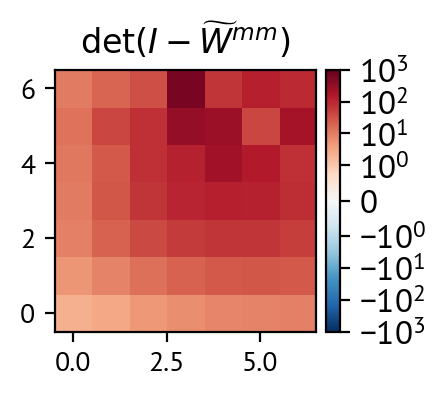

In [13]:
fig,axs = plt.subplots(1,1,figsize=(2.2*1,1.7*1),dpi=200)

cbar = imshowbar(fig,axs,J_detAm[:,:].T,origin="lower",cmap="RdBu_r",norm=mpl.colors.SymLogNorm(vmin=-1e3,vmax=1e3,linthresh=1))
# axs[1,1].imshow(J_vsm_diff_stds,origin="lower",vmin=diff_std_lolim,vmax=diff_std_uplim)
cbar.ax.tick_params(labelsize=12)

axs.set_title(r"$\mathrm{det}(I-\widetilde{W}^{mm})$",fontsize=12)

# fig.tight_layout()
fig.savefig("./supp_fig_1b.pdf", bbox_inches="tight")

# Plot Baseline-to-Matched Effective Interaction Matrix from Supp Fig S1c

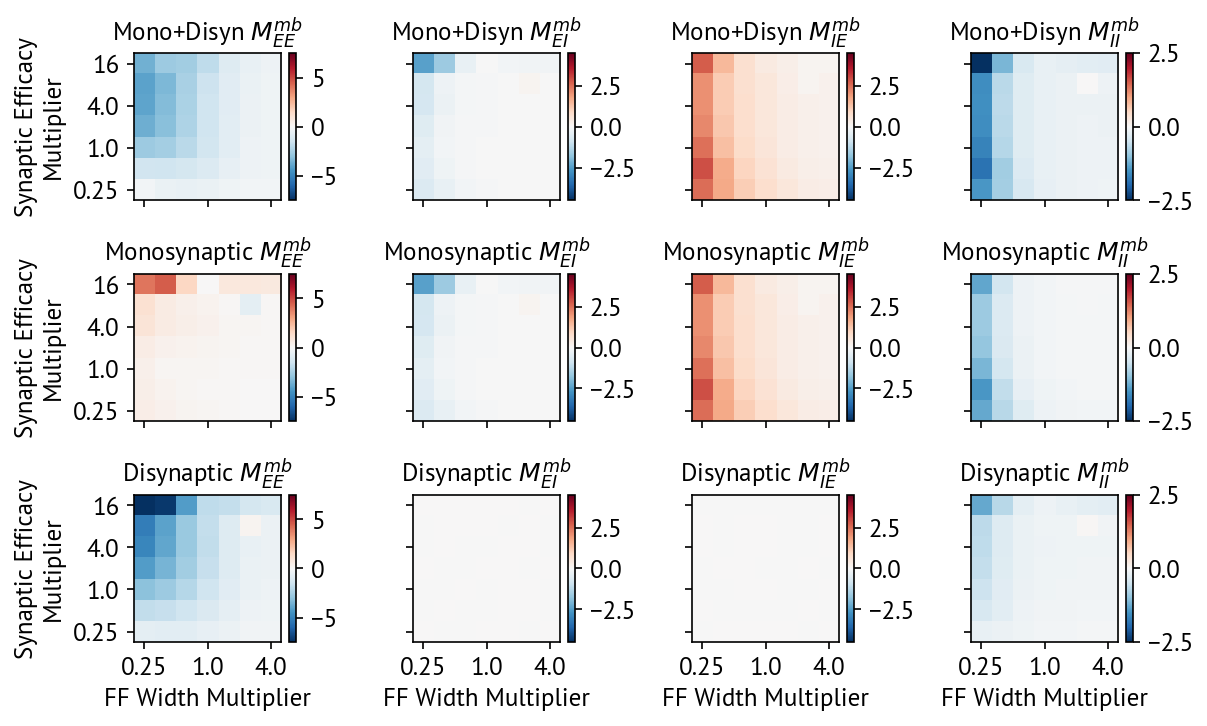

In [14]:
fig,axs = plt.subplots(3,4,figsize=(2.2*4,1.7*3),dpi=150,sharey="row",sharex="col")
fig.subplots_adjust(wspace=0.5,hspace=0.5)

conn_idxs = [[0,0],[0,1],[1,0],[1,1]]
vlim = [7.5,4.5,4.5,2.5]

for i in range(4):
    cbar = imshowbar(fig,axs[0,i],J_Xmb[:,:,*conn_idxs[i]].T,origin="lower",cmap="RdBu_r",vmin=-vlim[i],vmax=vlim[i])
    cbar.ax.tick_params(labelsize=12)
    cbar = imshowbar(fig,axs[1,i],J_Xmb1[:,:,*conn_idxs[i]].T,origin="lower",cmap="RdBu_r",vmin=-vlim[i],vmax=vlim[i])
    cbar.ax.tick_params(labelsize=12)
    cbar = imshowbar(fig,axs[2,i],J_Xmb2[:,:,*conn_idxs[i]].T,origin="lower",cmap="RdBu_r",vmin=-vlim[i],vmax=vlim[i])
    cbar.ax.tick_params(labelsize=12)

for i in range(3):
    axs[i,0].set_ylabel("Synaptic Efficacy\nMultiplier",fontsize=12)
    axs[i,0].set_yticks(np.arange(0,7,2),["0.25","1.0","4.0","16"],
                    fontsize=12)

for i in range(4):
    axs[-1,i].set_xticks(np.arange(0,7,3),["0.25","1.0","4.0"],
                        fontsize=12)
    axs[-1,i].set_xlabel("FF Width Multiplier",fontsize=12)

axs[0,0].set_title(r"Mono+Disyn $M_{EE}^{mb}$",fontsize=12)
axs[0,1].set_title(r"Mono+Disyn $M_{EI}^{mb}$",fontsize=12)
axs[0,2].set_title(r"Mono+Disyn $M_{IE}^{mb}$",fontsize=12)
axs[0,3].set_title(r"Mono+Disyn $M_{II}^{mb}$",fontsize=12)

axs[1,0].set_title(r"Monosynaptic $M_{EE}^{mb}$",fontsize=12)
axs[1,1].set_title(r"Monosynaptic $M_{EI}^{mb}$",fontsize=12)
axs[1,2].set_title(r"Monosynaptic $M_{IE}^{mb}$",fontsize=12)
axs[1,3].set_title(r"Monosynaptic $M_{II}^{mb}$",fontsize=12)

axs[2,0].set_title(r"Disynaptic $M_{EE}^{mb}$",fontsize=12)
axs[2,1].set_title(r"Disynaptic $M_{EI}^{mb}$",fontsize=12)
axs[2,2].set_title(r"Disynaptic $M_{IE}^{mb}$",fontsize=12)
axs[2,3].set_title(r"Disynaptic $M_{II}^{mb}$",fontsize=12)

# fig.tight_layout()
fig.savefig("./supp_fig_1c.pdf", bbox_inches="tight")